# Model System Notebook 3: NRSS

Notebook 3 covers how we build an NRSS model to simulate RSoXS. A random sequential addition (RSA) algorithm is used to build up the system of multi-walled carbon nanotubes (MWCNTs), which is then converted into an NRSS model and simulated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
import xarray as xr
from fiberRSA.fiberRSA import create_random_CNT, create_all_CNT, upscale_all_CNTs, dilate_all_par, dilate_all_par_hollow, find_angles
import cupy as cp
import pandas as pd
from skimage.transform import downscale_local_mean

In [2]:
from PyHyperScattering.integrate import WPIntegrator
integrator = WPIntegrator()

Imports failed.  Are you running on a machine with proper libraries for databroker, tiled, etc.?


In [3]:
sys.path.append('/home/pjd/lib/NRSS/src')

In [4]:
from NRSS.morphology import OpticalConstants, Material, Morphology
from NRSS.visualizer import morphology_visualizer

CyRSoXS
Size of Real               : 4
Maximum Number Of Material : 32
 __________________________________________________________________________________________________
|                                 Thanks for using CyRSoXS                                        |
|--------------------------------------------------------------------------------------------------|
|  Copyright          : Iowa State University                                                      |
|  License            : NIST                                                                       |
|  Acknowledgement    : ONR MURI                                                                   |
|                                                                                                  |
|  Developed at Iowa State University in collaboration with NIST                                   |
|                                                                                                  |
|  Please cite the fol

## Random Sequential Addition

The Random Sequential Addition algorithm:
1. Choose distributions for MWCNT orientation, radius, and length. Additional parameters that can be set are hollow fraction of the tube, and box dimensions in X, Y, and Z.
2. A test MWCNT is created by sampling from the distributions in orientation, radius, and length, and randomly placing it inside the morphology.
3. Overlap is tested between the test MWCNT and all other MWCNTs already in the morphology.
4. If there is no overlap, the MWCNT is added to the list of placed MWCNTs. If there is overlap, the test MWCNT is discarded.
5. Repeat steps 2-4 for N trials, or until the morphology reaches a threshold MWCNT density.

Steps 1-5 are encapsulted in the function `create_all_CNT`. We have chosen a log-normal distribution for MWCNT radius, a uniform distribution for length, and gaussian distributions for the two Euler angles, psi and theta. Values to define specific instances of those distributions are input parameters for `create_all_CNT`. The base function that achieves Step 2 is `create_random_CNT`. To illustrate the base function, we can choose values for `BoxXY`, `BoxZ`, `theta`, `psi`, `length`, and `radius` and call the function once to create a single CNT object

In [5]:
BoxXY = 512
BoxZ = 128
theta = np.random.random()*np.pi/2
psi = np.random.random()*np.pi*2
length = 100
radius = 2
single_CNT = create_random_CNT(BoxXY, BoxZ, theta, psi, length, radius)

Creating a single CNT with random orientation, we can see the object an instance of the CNT class, which itself is a Numba jitclass. Numba compiles the class to speed up compute.

In [6]:
single_CNT

We can plot the xyz values for each point sampled along the MWCNT central axis

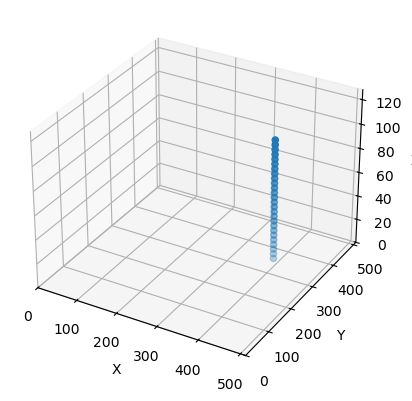

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(single_CNT.x, single_CNT.y, single_CNT.z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,512)
ax.set_ylim(0,512)
ax.set_zlim(0,128)
plt.show()

`create_random_CNT` is called within `create_all_CNT` for each trial insertion of a new MWCNT. Here we attempt to insert 1000 CNTs into the box.

In [8]:
BoxXY = 2048
BoxZ = 256
num_trials = 20000
radius_mu = 2.32
radius_sigma = 0.275
theta_mu = np.pi/2
theta_sigma = 0.2
length_lower = 75
length_upper = 300
all_CNTs = create_all_CNT(num_trials, radius_mu, radius_sigma, theta_mu, theta_sigma, length_lower, length_upper, BoxXY, BoxZ)

In [9]:
len(all_CNTs)

2637

For 20000 trials, we are only able to successfully place ~2600 CNTs into the box, a success rate of 13%. The success rate will continue to go down as we pack more CNTs into a box. Plotting the list of CNTs returned by `create_all_CNTs`, we can see the CNTs are contained within the 128x512x512 (ZYX) box.

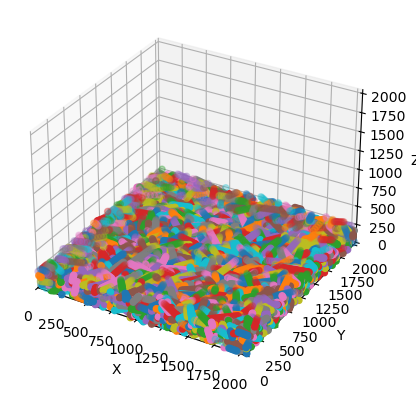

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for CNT in all_CNTs:
    ax.scatter(CNT.x, CNT.y, CNT.z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,2048)
ax.set_ylim(0,2048)
ax.set_zlim(0,2048)
plt.show()

The next step is to take the list of CNTs, each of which contain a list of coordinates, and translate them into a 3D voxel-based array. To do that, we upscale the sampling of coordinates and perform a dilation operation. The CNT coordinates were sampled at a lower resolution for trial placements to make the intersection algorithm more efficient. At this time we can also create the `S` array, which holds values for the degree of alignment in each voxel. For these simulations, we assign S=1 for voxels containing CNT and zero elsewhere.

In [11]:
upscale_all_CNTs(all_CNTs, BoxXY, BoxZ)

hollow_fraction = 0.5
CNTs_dilated = np.zeros((BoxZ, BoxXY, BoxXY))
S = CNTs_dilated.copy()
dilate_all_par_hollow(all_CNTs, CNTs_dilated, BoxXY, BoxZ, hollow_fraction, inside_value=0)
dilate_all_par_hollow(all_CNTs, S, BoxXY, BoxZ, hollow_fraction, inside_value=0)

/home/pjd/lib/NRSS/src/NRSS_tutorials/MWCNTs/fiberRSA/fiberRSA.py:447: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  r = np.linspace(-CNTs[i].length/2, CNTs[i].length/2, int(CNTs[i].length+1))


We can plot a slice of the dilated array to show how the CNT central axis locations have been translated into the 3D voxel array. `dilate_all_par_hollow` does two dilation operations. The first creates a solid CNT with value 1. The second dilation operation goes back and assigns a value of zero to the interior of the CNT corresponding to radius*hollow_fraction.

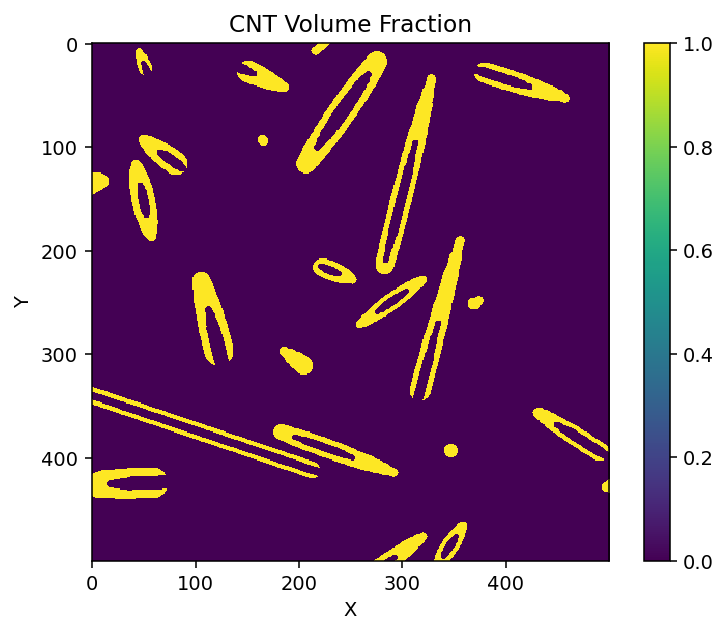

In [12]:
plt.figure(dpi=140)
plt.imshow(CNTs_dilated[128,:500,:500], interpolation='none')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('CNT Volume Fraction')
plt.colorbar()
plt.show()

We can also sum up along the z-axis to plot a projection of the 3D voxel array.

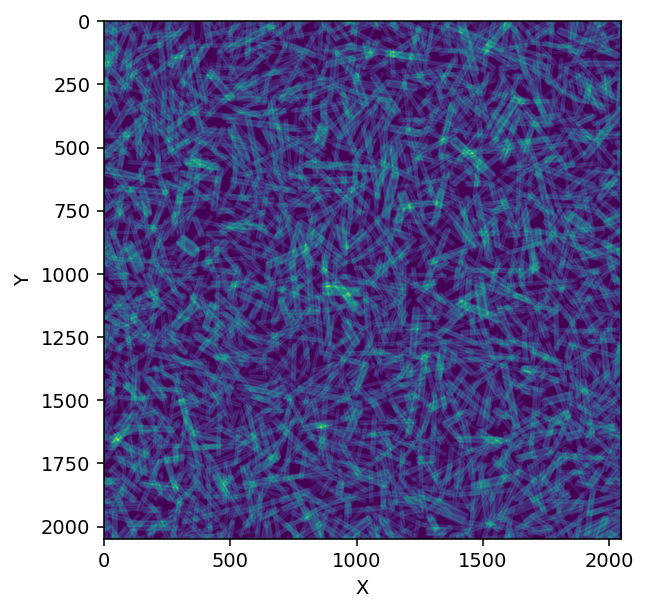

In [13]:
plt.figure(dpi=140)
plt.imshow(np.sum(CNTs_dilated, axis=0))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Next, we need to find the Euler angles which define the alignment of the uniaxial dielectric function within each voxel. This is done with the `find_angles` function. However, our 256x2048x2048 array will not fit on the GPU, so we need to downscale it to 128x1024x1024 first.

In [14]:
CNTs_dilated = downscale_local_mean(CNTs_dilated, (2,2,2))
S = downscale_local_mean(S, (2,2,2))

In [15]:
theta, psi = find_angles(CNTs_dilated)
theta_np = cp.asnumpy(theta)
psi_np = cp.asnumpy(psi)

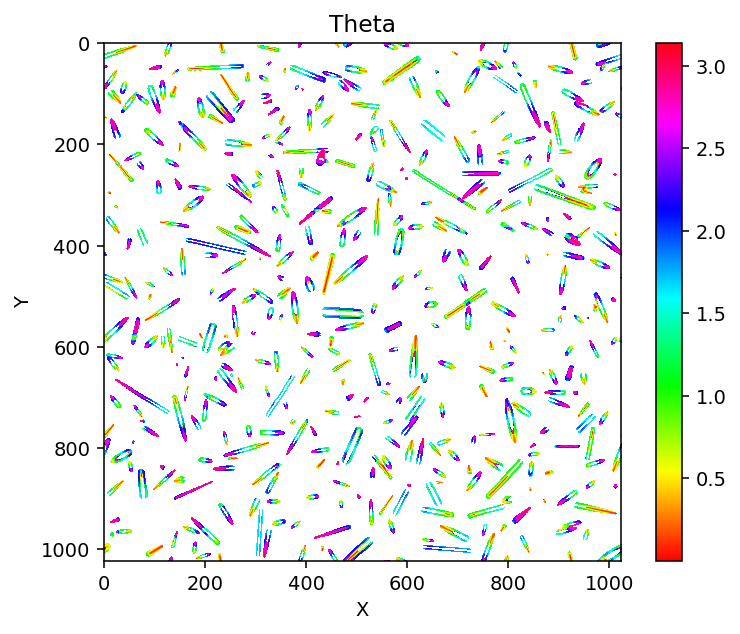

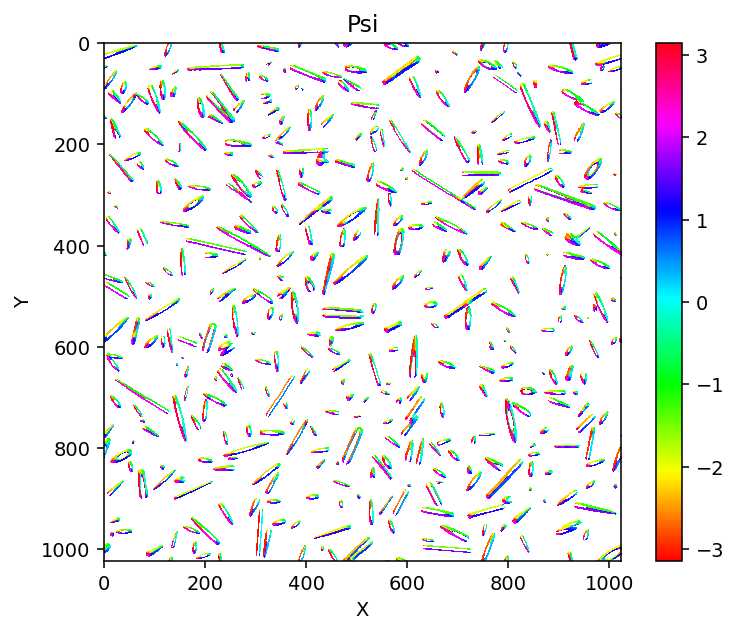

In [16]:
plt.figure(dpi=140)
plt.imshow(np.ma.masked_array(theta_np[32,:,:], ~CNTs_dilated[32,:,:].astype(bool)), cmap='hsv', interpolation='none')
plt.title('Theta')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
plt.figure(dpi=140)
plt.imshow(np.ma.masked_array(psi_np[32,:,:], ~CNTs_dilated[32,:,:].astype(bool)), cmap='hsv', interpolation='none')
plt.title('Psi')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

We now have the volume fraction, theta, and psi for the CNTs defined in a 3D array. And because the system is two components (CNTs and vacuum), we can easily find the volume fraction for vacuum. Additionally, vacuum will have no alignment, so we can set the vacuum arrays for theta and psi to be all zeros. The two final pieces of information are the optical constants we derived in notebook 2, and the energies we want to simulate. We can match the experimental energies in our simulations

In [155]:
# load in optical constants as pandas dataframe
pd_MWCNT = pd.read_csv('Data/MWCNT_opts.csv')
# pd_MWCNT['BetaPara'] = pd_MWCNT['BetaPara']+1.7e-5
# load reduced RSoXS data in as xarray data arrays
CNT_saxs = xr.load_dataarray('Data/RSoXS/CNT_pol0_SAXS.nc')
CNT_waxs = xr.load_dataarray('Data/RSoXS/CNT_pol0_WAXS.nc')

# interpolate optical constants to the energies measured in experimental RSoXS
energies_to_sim = CNT_waxs.energy.values
MWCNT_opts = OpticalConstants.calc_constants(energies_to_sim, pd_MWCNT)

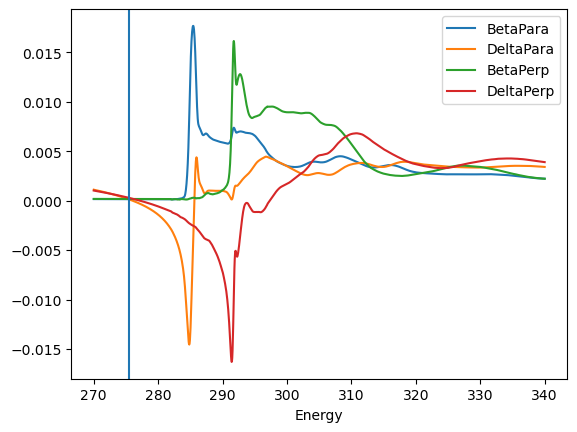

In [191]:
pd_MWCNT.plot(x='Energy')
plt.axvline(275.5)
# plt.xlim(270,280)
# plt.ylim(-0.001,0.001)

And now we can construct a full NRSS simulation. We start by creating `Material` objects for the MWCNT and vacuum components.

In [73]:
S = CNTs_dilated.copy() # all CNT material is fully aligned at S=1
mat1 = Material(Vfrac=CNTs_dilated, S=S, theta=theta_np, psi=psi_np, energies=energies_to_sim, name='MWCNT')
mat1.opt_constants = MWCNT_opts.opt_constants

vacuum_space = 1.0 - CNTs_dilated
Svac = np.zeros(vacuum_space.shape)
mat2 = Material(Vfrac=vacuum_space, S=Svac, theta=Svac, psi=Svac, energies=energies_to_sim, name='vacuum')

The `Material` objects, as well as parameters for running the simulation are contained within a `Morphology` object.

In [74]:
# set our configuration dictionary for the Morphology object
config = {'CaseType':0, 'MorphologyType':0, 'WindowingType':1, 'Energies':energies_to_sim, 'EAngleRotation':[0.0, 1.0, 0.0]}
morph = Morphology(2, {1:mat1, 2:mat2}, PhysSize=1, config=config)

Before running the simulation we can validate that the `Morphology` doesn't contain any invalid values

In [75]:
morph.validate_all(quiet=False)

All material checks have passed
All objects have been validated successfully. You can run your simulation


We can also visualize the morphology with the built-in visualizer, which allows us to visually inspect slices of the model.

Dataset dimensions (Z, Y, X): 128 x 1024 x 1024
Number of Materials: 2

Material 1 Vfrac. Min: 0.0 Max: 1.0
Material 1 S. Min: 0.0 Max: 1.0
Material 1 theta. Min: 0.0 Max: 3.141592653589793
Material 1 psi. Min: -3.141592653589793 Max: 3.141592653589793


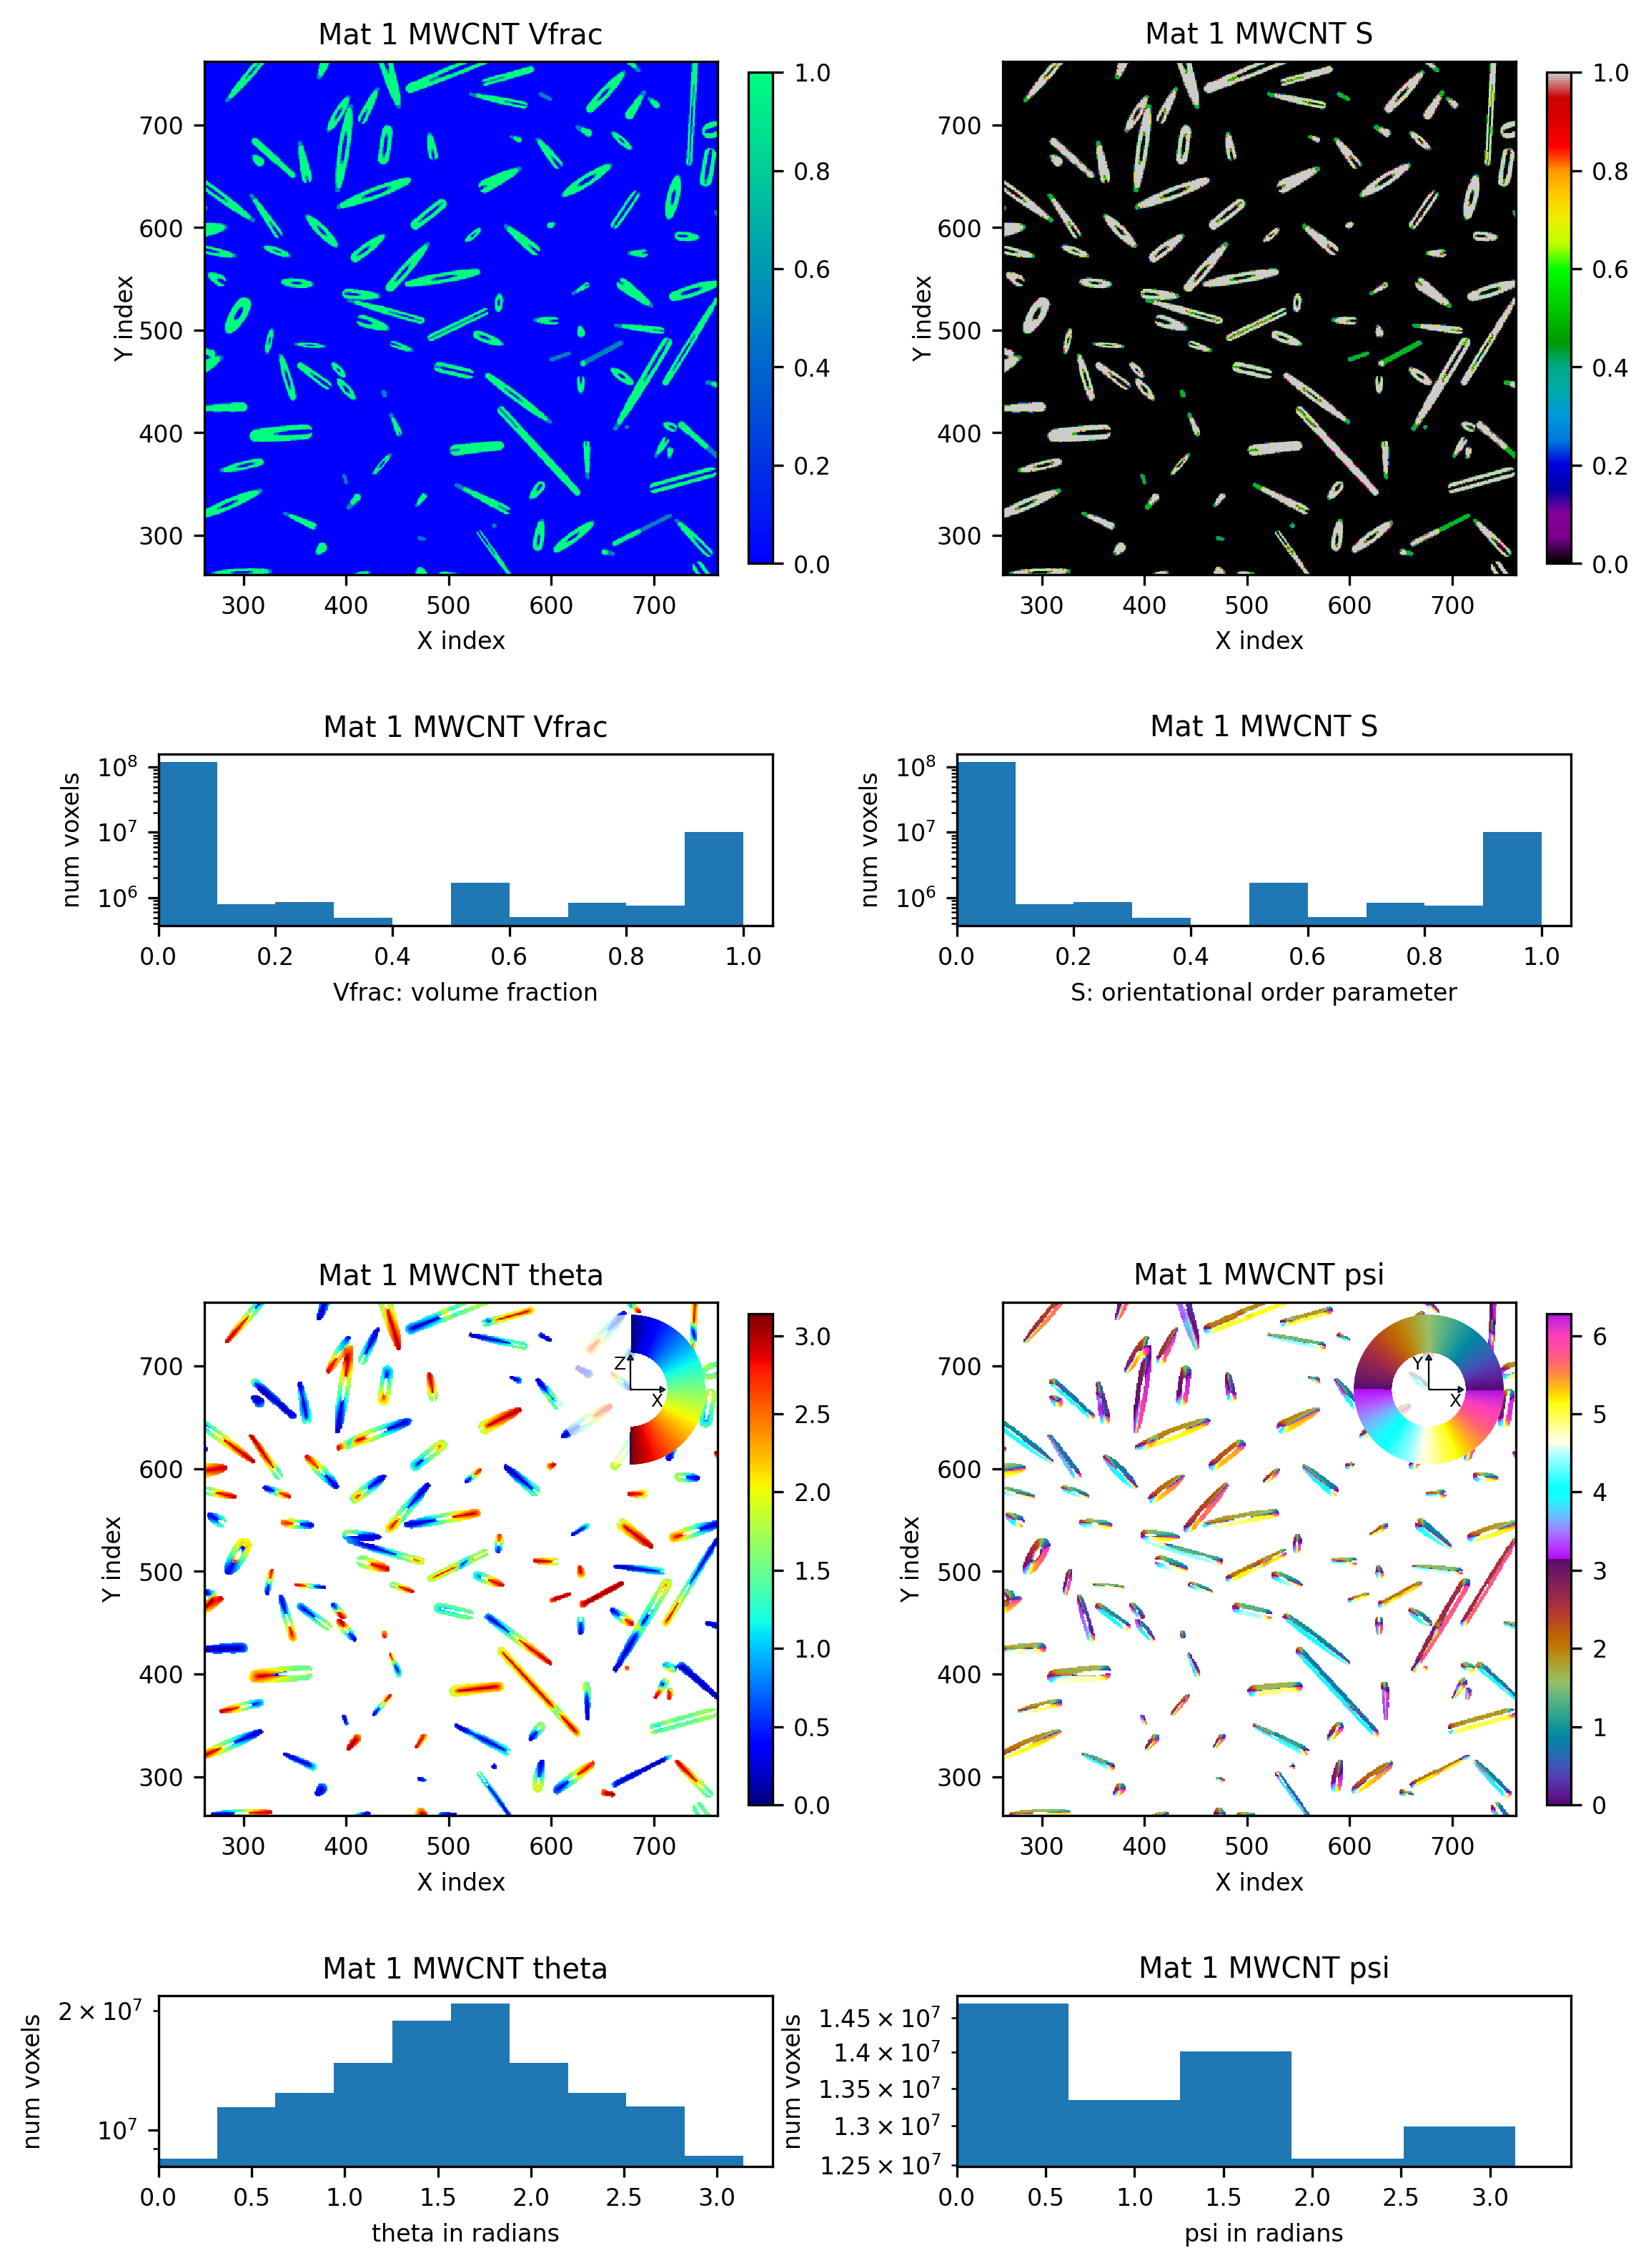

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 0.0
Material 2 theta. Min: 0.0 Max: 0.0
Material 2 psi. Min: 0.0 Max: 0.0


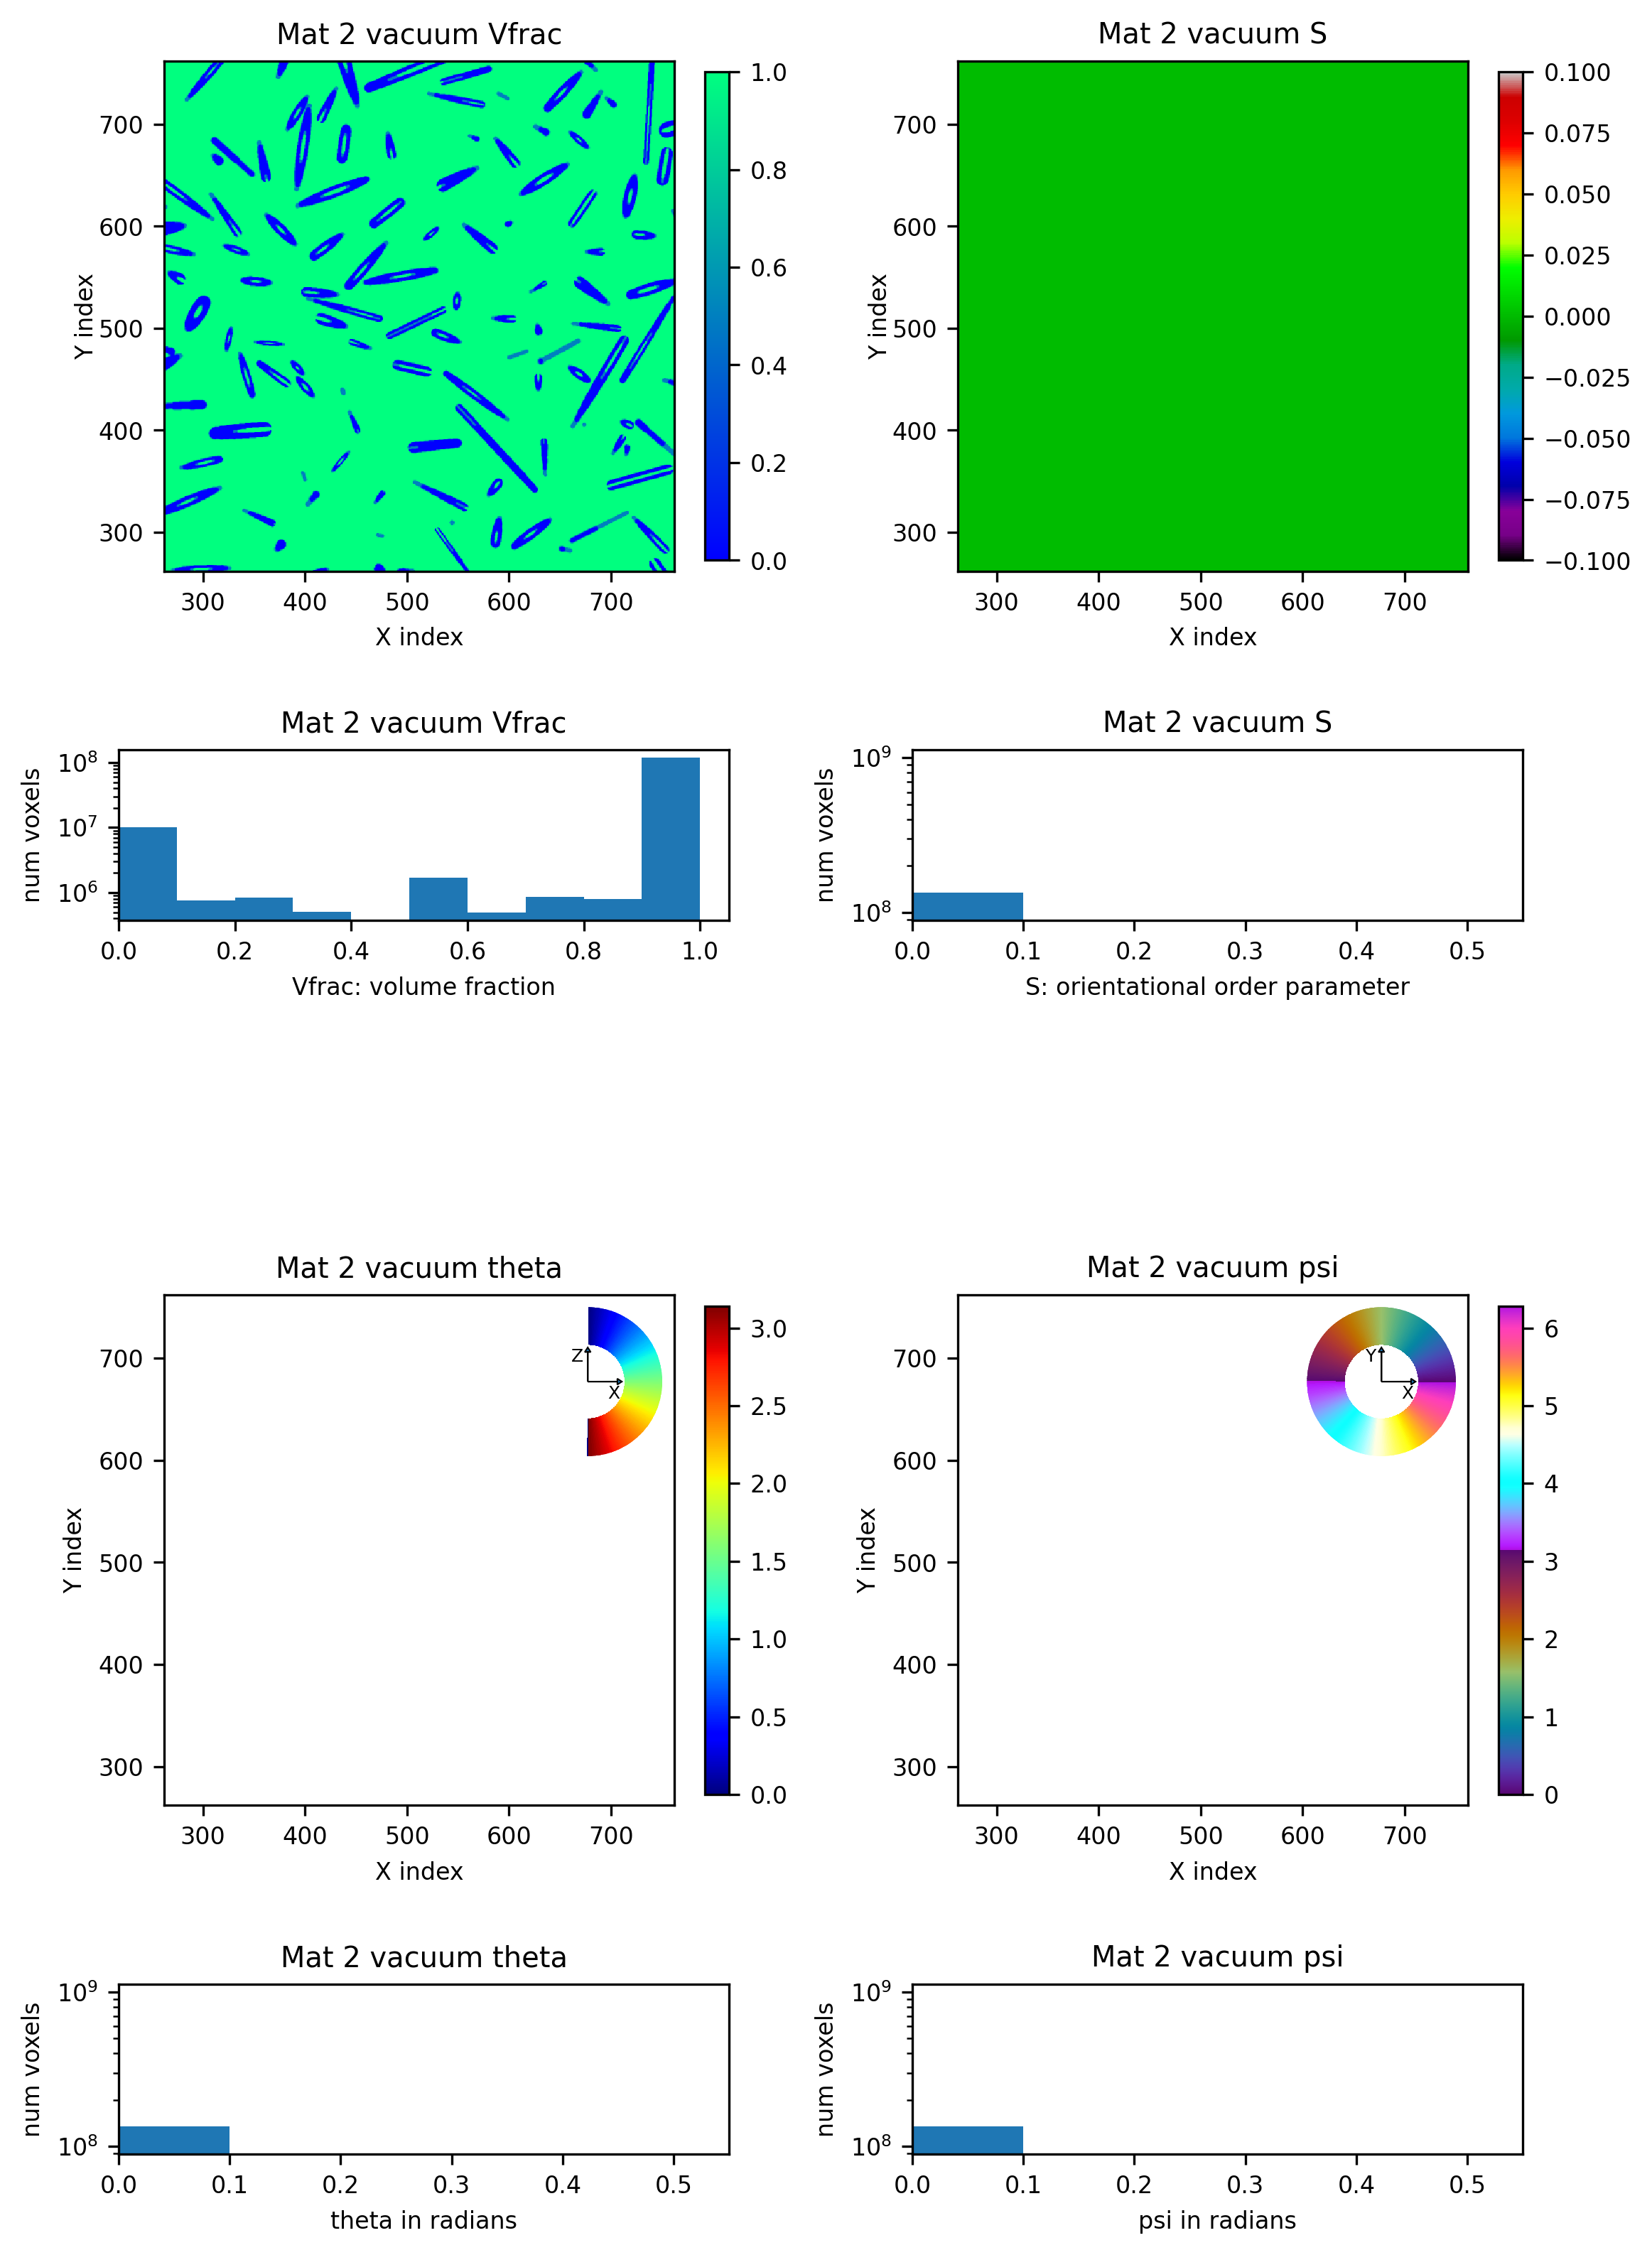

[]

<Figure size 640x480 with 0 Axes>

In [76]:
morphology_visualizer(morph,z_slice=64,subsample=500)

The simulation is run with a simple `.run` command. It will output the simulation results as an xarray DataArray.

In [77]:
scattering = morph.run(stdout=False, stderr=False)

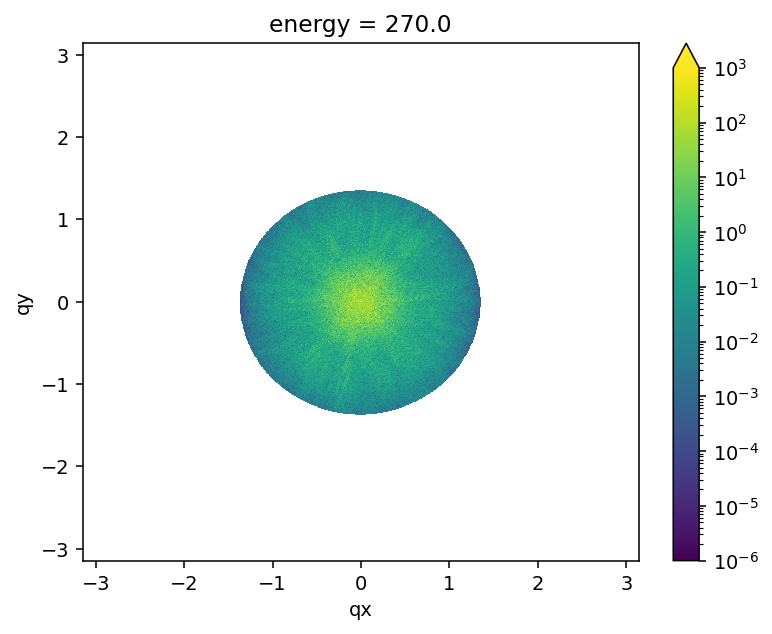

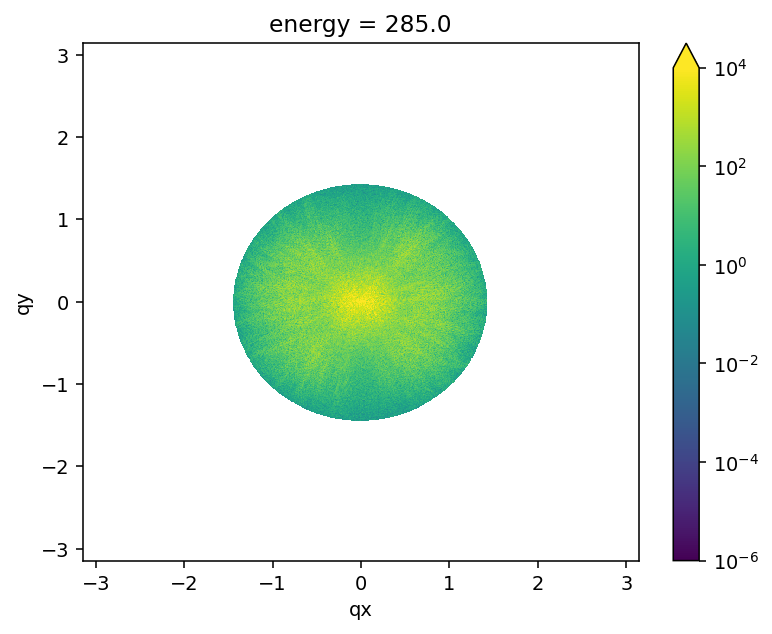

In [78]:
plt.figure(dpi=140)
scattering.sel(energy=270).plot(norm=LogNorm(1e-6,1e3))
plt.figure(dpi=140)
scattering.sel(energy=285).plot(norm=LogNorm(1e-6,1e4))

In [79]:
scattering_remeshed = integrator.integrateImageStack(scattering)

  0%|          | 0/55 [00:00<?, ?it/s]

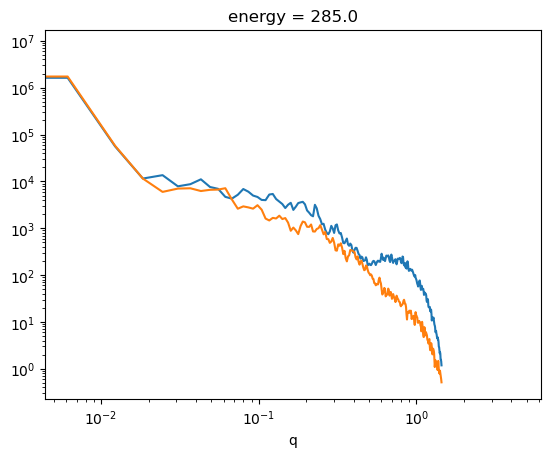

In [80]:
scattering_remeshed.sel(energy=285,chi=slice(-20,20)).mean('chi').plot(yscale='log',xscale='log')
scattering_remeshed.sel(energy=285,chi=slice(70,90)).mean('chi').plot(yscale='log',xscale='log')

Despite the relatively large simulation, the resulting simulations are considerably noisier than the experimental data. To combat this, for subsequent simulations, we can average over 3 independent simulations for the same input parameters

In [196]:
radius_mu = 2.225
radius_sigma = 0.23
length_lower=75
length_upper=300
hollow_fraction = .325
theta_mu = np.pi/2
theta_sigma = 1/2/np.pi
BoxXY = 2048
BoxZ = 256
inside_value = 0
S_inside = 0

num_repeats = 1
scattering_chi_all = np.zeros((55,360,725))

for repeat in range(num_repeats):
    all_CNTs = create_all_CNT(num_trials, radius_mu, radius_sigma, theta_mu, theta_sigma, length_lower, length_upper, BoxXY, BoxZ)
    
    upscale_all_CNTs(all_CNTs, BoxXY, BoxZ)
    
    CNTs_dilated = np.zeros((BoxZ, BoxXY, BoxXY))
    S = CNTs_dilated.copy()
    dilate_all_par_hollow(all_CNTs, CNTs_dilated, BoxXY, BoxZ, hollow_fraction, inside_value=0)
    dilate_all_par_hollow(all_CNTs, S, BoxXY, BoxZ, hollow_fraction, inside_value=0)
    
    CNTs_dilated = downscale_local_mean(CNTs_dilated, (2,2,2))
    CNTs_dilated += np.random.random(size=CNTs_dilated.shape)*0.05
    CNTs_dilated[CNTs_dilated > 1] = 1
    S = downscale_local_mean(S, (2,2,2))
    # S[S>0] = 1
    theta, psi = find_angles(CNTs_dilated)
    theta_np = cp.asnumpy(theta)
    psi_np = cp.asnumpy(psi)
    
    S = CNTs_dilated.copy() # all CNT material is fully aligned at S=1
    mat1 = Material(Vfrac=CNTs_dilated, S=S, theta=theta_np, psi=psi_np, energies=energies_to_sim, name='MWCNT')
    mat1.opt_constants = MWCNT_opts.opt_constants
    
    vacuum_space = 1.0 - CNTs_dilated
    Svac = np.zeros(vacuum_space.shape)
    mat2 = Material(Vfrac=vacuum_space, S=Svac, theta=Svac, psi=Svac, energies=energies_to_sim, name='vacuum')
    
    # set our configuration dictionary for the Morphology object
    config = {'CaseType':0, 'MorphologyType':0, 'WindowingType':1, 'Energies':energies_to_sim, 'EAngleRotation':[0.0, 1.0, 0.0]}
    morph = Morphology(2, {1:mat1, 2:mat2}, PhysSize=1, config=config)
    
    scattering = morph.run(stdout=False, stderr=False)
    scattering['qx'] = scattering.qx/10
    scattering['qy'] = scattering.qy/10
    scattering_chi = integrator.integrateImageStack(scattering)
    scattering_chi_all += scattering_chi.values


scattering_chi_all /= num_repeats
scattering_chi_all = xr.DataArray(scattering_chi_all, dims=['energy', 'chi', 'q'], coords={'energy':scattering_chi.energy, 'chi':scattering_chi.chi, 'q':scattering_chi.q})

  0%|          | 0/55 [00:00<?, ?it/s]

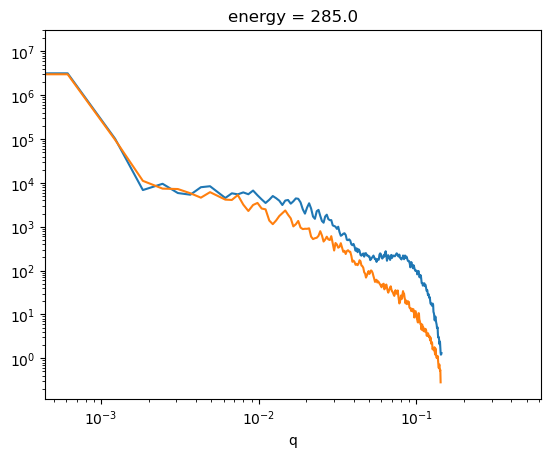

In [197]:
scattering_chi_all.sel(energy=285,chi=slice(-20,20)).mean('chi').plot(yscale='log',xscale='log')
scattering_chi_all.sel(energy=285,chi=slice(-110,-90)).mean('chi').plot(yscale='log',xscale='log')

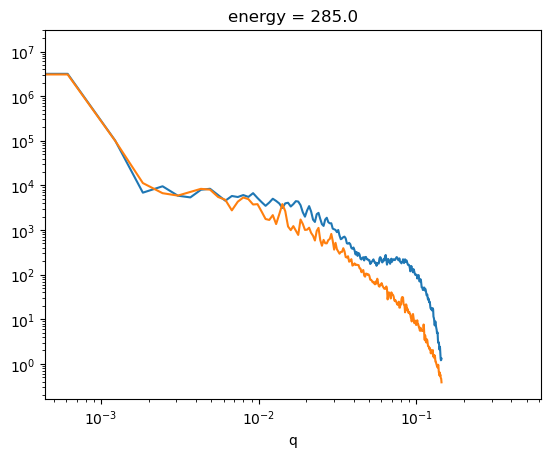

In [198]:
scattering_chi_all.sel(energy=285,chi=slice(-20,20)).mean('chi').plot(yscale='log',xscale='log')
scattering_chi_all.sel(energy=285,chi=slice(70,90)).mean('chi').plot(yscale='log',xscale='log')

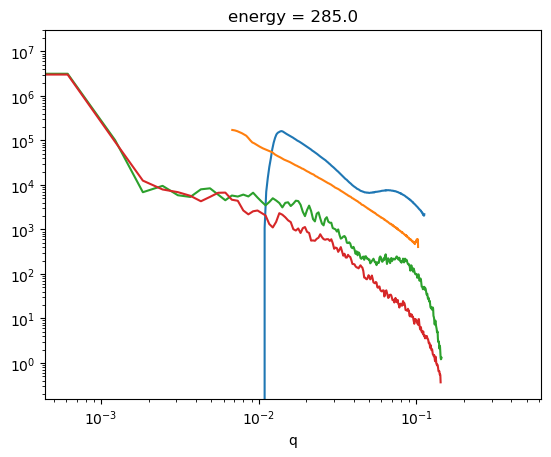

In [199]:
CNT_waxs.sel(energy=285, chi=slice(-20,20)).mean('chi').plot(yscale='log',xscale='log')
CNT_waxs.sel(energy=285, chi=slice(-110,-70)).mean('chi').plot(yscale='log',xscale='log')

scattering_chi_all.sel(energy=285,chi=slice(-20,20)).mean('chi').plot(yscale='log',xscale='log')
scattering_chi_all.sel(energy=285,chi=slice(-110,-70)).mean('chi').plot(yscale='log',xscale='log')

In [200]:

### upper left plot
exp_ax0 = CNT_waxs.sel(energy=285, chi=slice(-20,20)).mean('chi')
exp_ax0_1 = CNT_waxs.sel(energy=285, chi=slice(-110,-70)).mean('chi')
exp_ax0_saxs = CNT_saxs.sel(energy=285, chi=slice(-20,20)).mean('chi')
exp_ax0_1_saxs = CNT_saxs.sel(energy=285, chi=slice(-110,-70)).mean('chi')

norm_val = exp_ax0.sel(q=slice(0.06,0.07)).mean('q')
### upper right plot
isi_exp = CNT_waxs.sel(q=slice(0.06,0.07)).mean(['q','chi'])
exp_ax1 = (isi_exp/isi_exp.sel(energy=285))

### lower left plot
A_exp = (CNT_waxs.sel(chi=slice(-20,20)).mean('chi') - CNT_waxs.sel(chi=slice(-110,-70)).mean('chi')) / ((CNT_waxs.sel(chi=slice(-20,20)).mean('chi') + CNT_waxs.sel(chi=slice(-110,-70)).mean('chi')))
exp_ax2 = A_exp.sel(energy=285).sel(q=slice(0.0175, 0.09))
exp_ax2_1 = A_exp.sel(energy=292).sel(q=slice(0.0175, 0.09))

### lower right plot
exp_ax3= A_exp.sel(q=slice(0.06, 0.07)).mean('q')


def plot_results(simulation_chi, radius_value, radius_sigma_value, hollow_value, count, show=False):
    fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=240)
    ax = ax.flatten()
    exp_ax0.plot(yscale='log',xscale='log', ax=ax[0],color='k',label='Exp')
    exp_ax0_1.plot(ax=ax[0], color='k', linestyle='--')
    # (exp_ax0_saxs*0.5e3).plot(ax=ax[0], color='k')
    # (exp_ax0_1_saxs*0.5e3).plot(ax=ax[0], color='k', linestyle='--')
    exp_ax1.plot(ax=ax[1], color='k')
    exp_ax2.plot(ax=ax[2], color='k')
    exp_ax2_1.plot(ax=ax[2], color='k', linestyle='--')
    exp_ax3.plot(ax=ax[3], color='k')


    horz = simulation_chi.sel(chi=slice(-20,20)).mean('chi')
    vert = simulation_chi.sel(chi=slice(-110,-70)).mean('chi')
    A = (horz - vert) / (horz + vert)
    isi_sim = simulation_chi.sel(q=slice(0.06,0.07)).mean(['q','chi'])
    
    ### simulation plotting
    (horz.sel(energy=285)/horz.sel(energy=285, q=slice(0.06,0.07)).mean('q')*norm_val).plot(ax=ax[0], label=hollow_fraction)
    (vert.sel(energy=285)/horz.sel(energy=285, q=slice(0.06,0.07)).mean('q')*norm_val).plot(ax=ax[0], label=hollow_fraction)    
    (isi_sim/isi_sim.sel(energy=285)).plot(ax=ax[1])
    A.sel(energy=285,q=slice(1e-4,.1)).plot(ax=ax[2])
    A.sel(energy=292, q=slice(1e-4, 0.1)).plot(ax=ax[2])
    A.sel(q=slice(0.06, 0.07)).mean('q').plot(ax=ax[3])

    plt.suptitle(f'r={radius_value} nm, sigma={radius_sigma_value}, fraction hollow={hollow_value}')
    ax[0].set_xlim(1e-3)
    ax[0].set_ylim(1e2, 5e6)
    ax[2].set_ylim(-1, 1)
    [axes.set_title('') for axes in ax]

    if show:
        plt.show()
    else:
        plt.savefig(f'parameter_sweep/figures/{count}.jpg', dpi=140, format='jpg', bbox_inches='tight')
        plt.close()

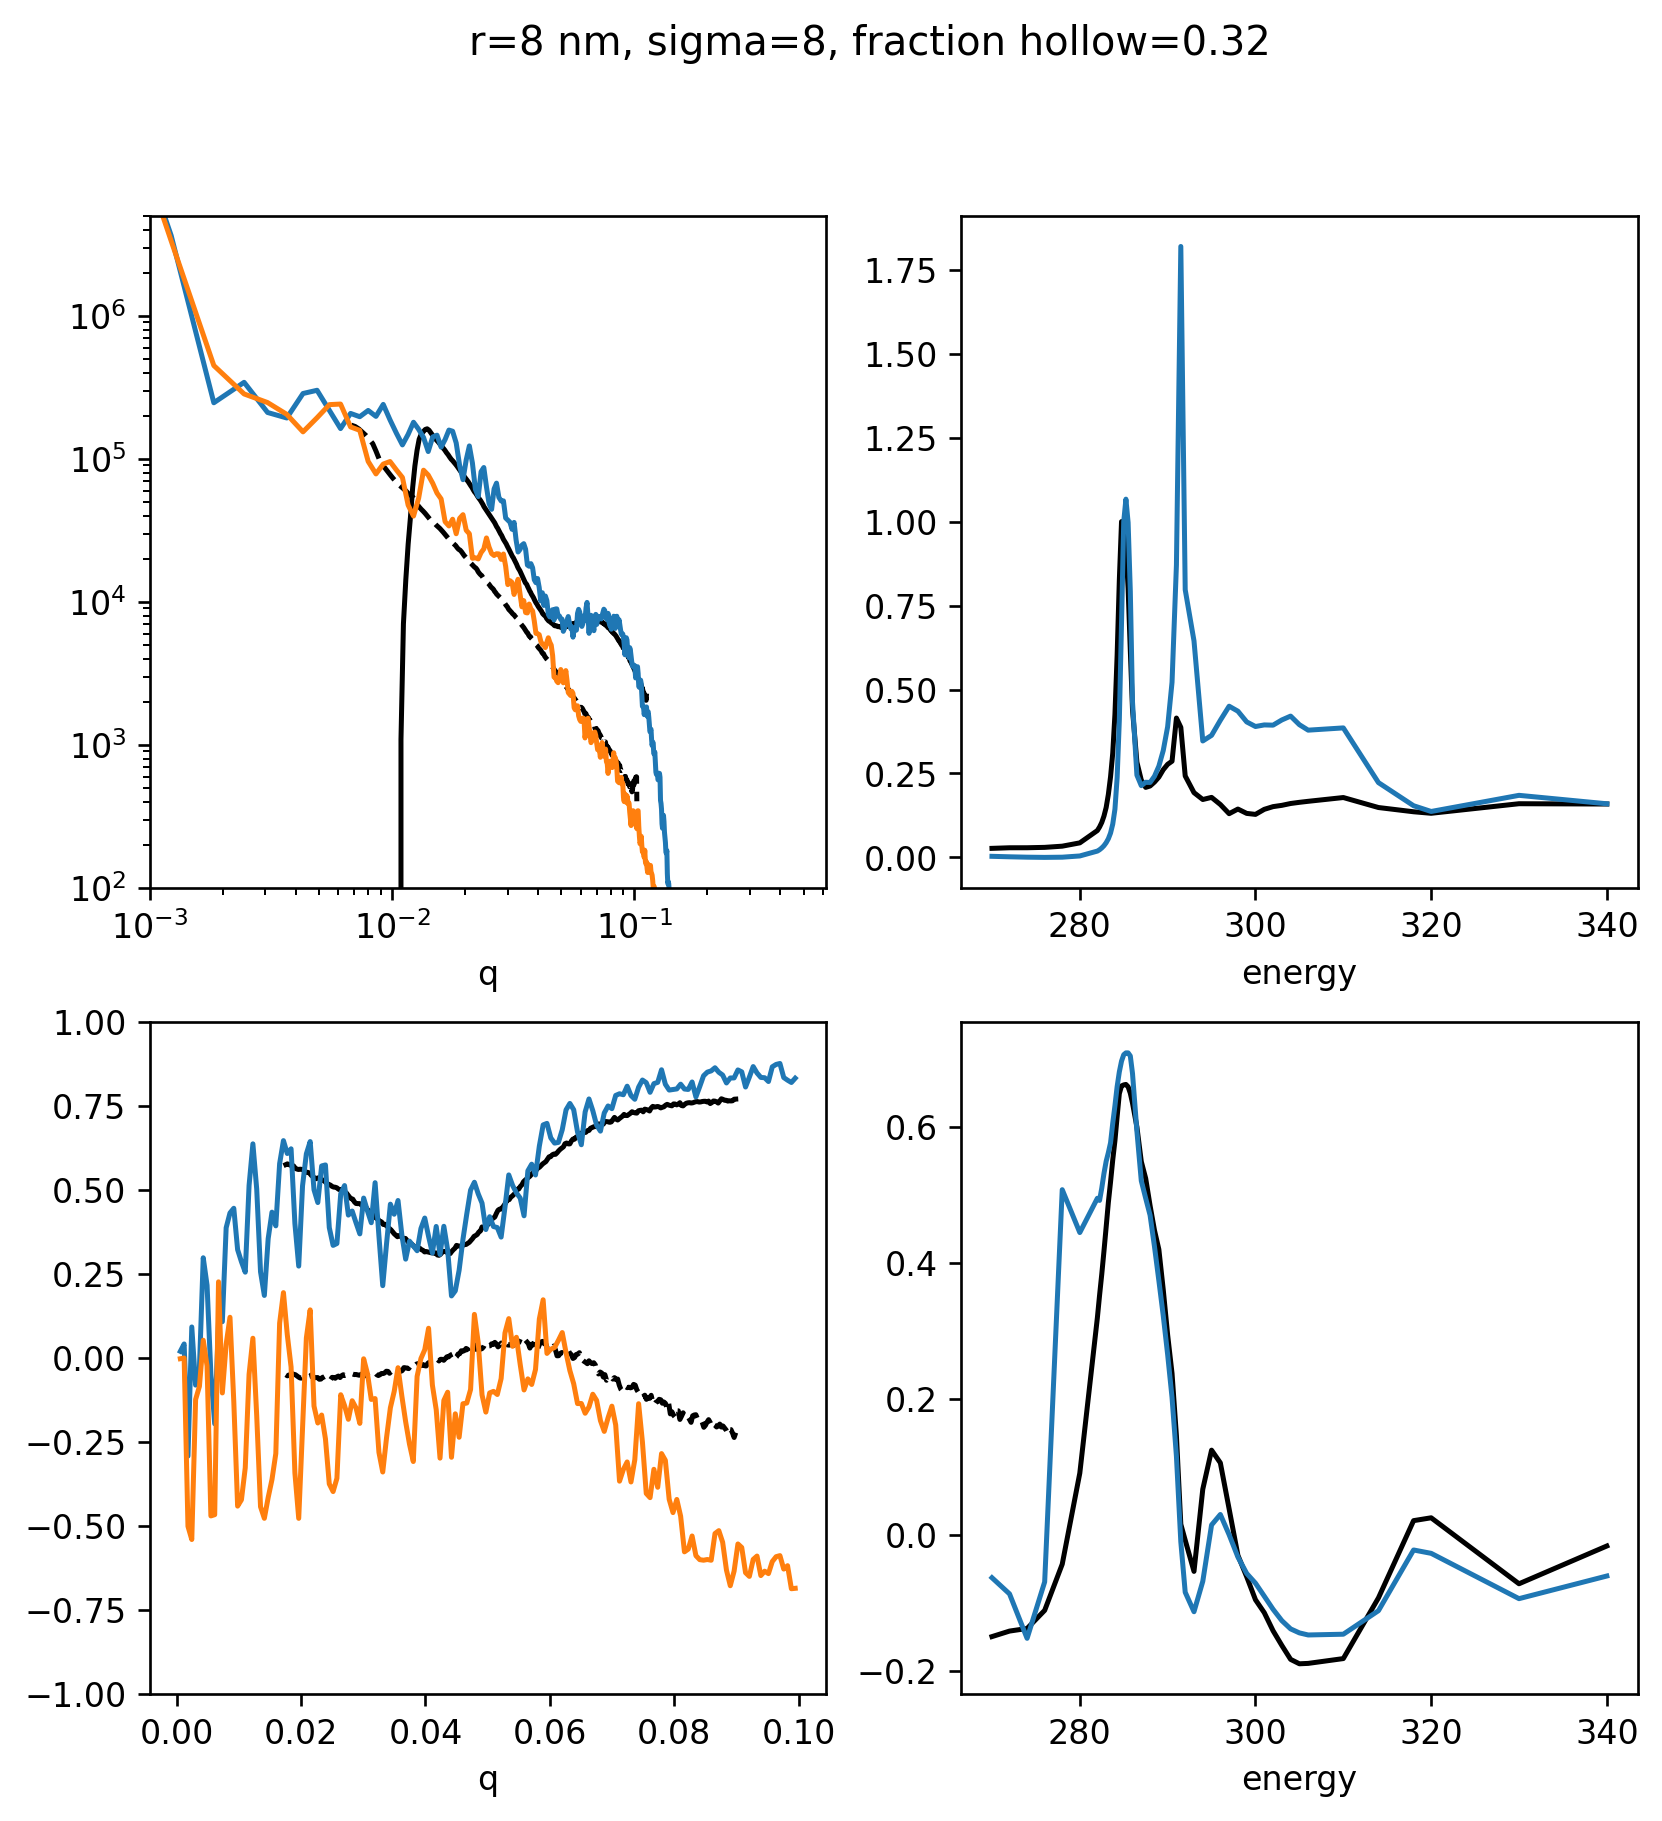

In [201]:
plot_results(scattering_chi_all, 8,8,0.32, 10, show=True)

In [202]:
horz = scattering_chi_all.sel(chi=slice(-20,20)).mean('chi')
vert = scattering_chi_all.sel(chi=slice(-110,-70)).mean('chi')
A = (horz - vert) / (horz + vert)

(0.001, 0.44459512274802987)

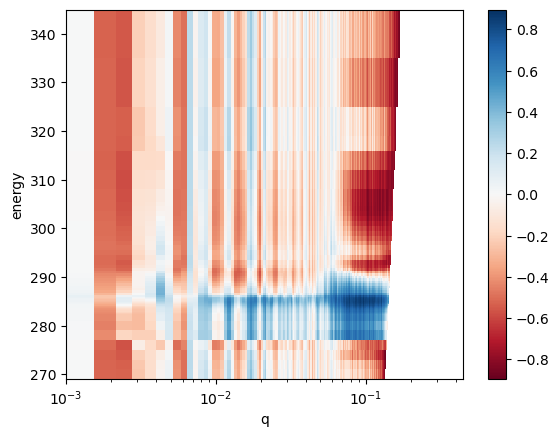

In [203]:
A.plot(cmap='RdBu')
plt.xscale('log')
plt.xlim(1e-3)

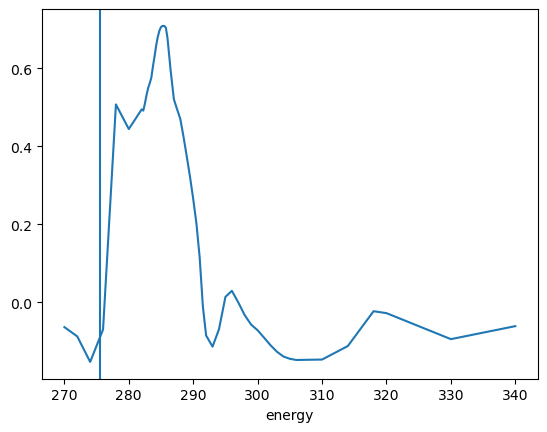

In [204]:
A.sel(q=slice(0.06,0.07)).mean('q').plot()
plt.axvline(275.5)

In [52]:
def Rz(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0],
                     [np.sin(angle), np.cos(angle), 0],
                     [0, 0, 1]])

def Ry(angle):
    return np.array([[np.cos(angle), 0, np.sin(angle)],
                    [0, 1, 0],
                    [-np.sin(angle), 0, np.cos(angle)]])


def create_R(theta, psi):
    rz = Rz(psi)
    ry = Ry(theta)
    return rz@ry


def create_uni_tensor(delta_ord, beta_ord, delta_ex, beta_ex):
    uni_tensor = np.zeros((delta_ord.shape[0], 3,3), dtype=complex)
    for i in range(len(uni_tensor)):
        uni_tensor[i, 0, 0] = complex(1-delta_ord[i], beta_ord[i])
        uni_tensor[i, 1, 1] = complex(1-delta_ord[i], beta_ord[i])
        uni_tensor[i, 2, 2] = complex(1-delta_ex[i], beta_ex[i])
    return uni_tensor

def create_uni_tensor2(nrss_opts):
    # [dPara, bPara, dPerp, bPerp]
    uni_tensor = np.zeros((len(nrss_opts), 3, 3), dtype=complex)
    for i, key in enumerate(nrss_opts.keys()):
        uni_tensor[i, 0, 0] = complex(1-nrss_opts[key][2], nrss_opts[key][3])
        uni_tensor[i, 1, 1] = complex(1-nrss_opts[key][2], nrss_opts[key][3])
        uni_tensor[i, 2, 2] = complex(1-nrss_opts[key][0], nrss_opts[key][1])
    return uni_tensor

def calculate_abs(R, dielectric, E, tfilm, wvl):
    nrot = R@dielectric@R.T
    p = 1/4/np.pi*(nrot@nrot - np.identity(3))@E
    beta_val = 2*np.pi*np.abs(p.imag)@E
    abs_val = np.exp(-4*np.pi/wvl*beta_val*tfilm)
    return abs_val


def calculate_abs_dist(dist, dielectric, E, tfilm, wvl):
    H, x_edges, y_edges = dist
    x_centers = np.diff(x_edges) + x_edges[:-1]
    y_centers = np.diff(y_edges) + y_edges[:-1]
    abs_vals = np.zeros(len(wvl))
    for ii, theta in enumerate(x_centers):
        for jj, psi in enumerate(y_centers):
            R = create_R(theta, psi)
            abs_vals += calculate_abs(R, dielectric, E, tfilm, wvl)*H[ii, jj]
    return abs_vals/np.sum(dist[0])

E = np.array([1,0,0])

In [5]:
BoxXY = 1024
BoxZ = 128
fibers = create_all_fiber(1000, 2.25, .275, np.pi/2, 1e-3, 75, 300, BoxXY, BoxZ, 1)
upscale_all_fibers(fibers, BoxXY, BoxZ)


fibers_dilated = np.zeros((BoxZ, BoxXY, BoxXY))
S = fibers_dilated.copy()
dilate_all_par_hollow(fibers, fibers_dilated, BoxXY, BoxZ, 0.5, inside_value=0)

/home/pjd/lib/NRSS/src/NRSS_tutorials/MWCNTs/fiberRSA/fiberRSA.py:206: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  r = np.linspace(-fibers[i].length/2, fibers[i].length/2, int(fibers[i].length+1))


In [ ]:
count=0
# log normal
radius_mu = 2.225
radius_sigma = 0.23
length_lower=75
length_upper=300
hollow_fraction = .325
theta_mu = np.pi/2
theta_sigma = 1/2/np.pi
BoxXY = 2048
BoxZ = 256
inside_value = 0
S_inside = 0


num_repeats = 3

all_fibers = []
scattering_chi_all = np.zeros((55,360,725))
global_dist = np.zeros((20,20))
            
for repeat in range(num_repeats):
    fibers = create_all_fiber(20000, radius_mu, radius_sigma, theta_mu, theta_sigma, length_lower, length_upper, BoxXY, BoxZ, 1)
    upscale_all_fibers(fibers, BoxXY, BoxZ)
    
    
    fibers_dilated = np.zeros((BoxZ, BoxXY, BoxXY))
    S = fibers_dilated.copy()
    dilate_all_par_hollow(fibers, fibers_dilated, BoxXY, BoxZ, hollow_fraction, inside_value=inside_value)
    dilate_all_par_hollow(fibers, S, BoxXY, BoxZ, hollow_fraction, inside_value=S_inside)
    
    fibers_dilated = downscale_local_mean(fibers_dilated, (2,2,2))
    S = downscale_local_mean(S, (2,2,2))
    theta, psi = find_angles(fibers_dilated)
    theta_np = cp.asnumpy(theta)
    psi_np = cp.asnumpy(psi)
    
    dist1 = np.histogram2d(theta_np[fibers_dilated != 0], psi_np[fibers_dilated != 0], bins=20, density=True,range=[[0,np.pi],[-np.pi, np.pi]])
    global_dist += dist1[0]
    ### NRSS ###
    vacuum_space = 1 - fibers_dilated
    
    mat1 = Material(Vfrac=fibers_dilated, S=S, theta=theta_np, psi=psi_np, energies=energies, name='HOPG')
    mat1.opt_constants = HOPG_opts.opt_constants
    
    Svac = np.zeros(vacuum_space.shape)
    
    mat2 = Material(Vfrac=vacuum_space, S=Svac, theta=Svac, psi=Svac, energies=energies, name='vacuum')
    
    config = {'CaseType':0, 'MorphologyType':0, 'WindowingType':1, 'Energies':energies, 'EAngleRotation':[0.0, 1.0, 360.0]}
    morph = Morphology(2, {1:mat1, 2:mat2}, PhysSize=1, config=config)
    
    scattering = morph.run(stdout=False, stderr=False)
    scattering['qx'] = scattering.qx/10
    scattering['qy'] = scattering.qy/10
    scattering_chi = integrator.integrateImageStack(scattering)
    scattering_chi_all += scattering_chi.values
    for fiber in fibers:
        all_fibers.append(np.round(fiber.radius))

    scattering_chi_all /= num_repeats
    scattering_chi_all = xr.DataArray(scattering_chi_all, dims=['energy', 'chi', 'q'], coords={'energy':scattering_chi.energy, 'chi':scattering_chi.chi, 'q':scattering_chi.q})
    scattering_chi_all.attrs['radius_mu'] = radius_mu
    scattering_chi_all.attrs['radius_sigma'] = radius_sigma
    scattering_chi_all.attrs['hollow_fraction'] = hollow_fraction
    scattering_chi_all.attrs['fiber_radii'] = all_fibers
    # scattering_chi_all.to_netcdf(f'parameter_sweep/data/paramsweep_{count}.nc')

global_abs = calculate_abs_dist([global_distj, dist1[1], dist1[2]],mwcnt_uni,E,100,wvl)
_ = save_plot(scattering_chi_all*global_abs[:,np.newaxis,np.newaxis], radius_mu, radius_sigma, hollow_fraction, count, show=True)